# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (morfemy). W przeciwieństwie do podejść lingwistycznych, wymagających reguł tworzenia morfemów, BPE wyznacza je automatycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków które występują obok siebie.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20) razy
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10) razy
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technike BPE na tych słowach.

Zaimplementuj algorytm BPE wykonujący `number_of_iterations` iteracji (łączeń symboli).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [2]:
import pandas as pd
import numpy as np
import time
from nltk import ngrams 
from collections import Counter
brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=None, names=['cluster', 'word', 'count'], dtype={'cluster': object})
#brown_df['word'] = brown_df['word'].astype(str)
brown_df = brown_df.dropna()
number_of_iterations = 10
def preform_bpe(brown_df, number_of_iterations):
    """
    Funckcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    brown_df = brown_df.copy()
    #print(brown_df.iloc[39445])
    t = time.time()
    V = set()
    
    def init(word, endTup):
       word = tuple(word) + endTup
       V.update(word)
       return word
    
    def updateCounter(word, ctr, count, subtract=False):
        pairs = ngrams(word,2)
        if subtract:
            val = -count
        else:
            val = count
        for ngram in pairs:
            ctr[ngram] += val
    
    def checkForNewSymbol(word, new_symb):
        return any(new_symb == word[i:len(new_symb) + i] for i in range(len(word) - len(new_symb) + 1))
    
    def replaceNewSymbol(word, new_symb):
        word = tuple(''.join(new_symb) if i-1<len(word)and word[i]==new_symb[0] and word[i+1]==new_symb[1] else word[i] for i in range(len(word)) if not(i>0 and word[i-1]==new_symb[0] and word[i]==new_symb[1])) 
        return word
    
    def func(word, ctr, counts, iterV, new_symb = None):
       if new_symb is None:
           updateCounter(word, ctr, counts.iloc[iterV[0]])
       else:
           if checkForNewSymbol(word, new_symb):
                cnt = counts.iloc[iterV[0]]
                updateCounter(word, ctr, cnt, subtract=True)
                word = replaceNewSymbol(word, new_symb)
                updateCounter(word, ctr, cnt)
       iterV[0] += 1
       return word
        
      
    endTup = tuple(['END'])
    initF = lambda x: init(x, endTup)
    brown_df['word']=brown_df['word'].apply(initF)
    
    #print("Init time: " +str(time.time()-t))
    
    new_symb = None
    ctr = Counter()
    counts = brown_df['count']
    for i in range(number_of_iterations):
        #print("Iter " + str(i+1))
        t = time.time()
        
        iterV = [0]
        fun = lambda x: func(x, ctr, counts, iterV, new_symb)
        brown_df['word'] = brown_df['word'].apply(fun)
        
        new_symb = ctr.most_common(1)[0][0]
        #print("New symbol: " + str(new_symb))
        joined = ''.join(new_symb)
        print(joined)
        V.update([joined])
        #print("Occurences: " +str(ctr.most_common(1)[0][1]))
        #print("Iter time: " +str(time.time()-t))
        #print(ctr.most_common(50))
        
    def finish(word, out):
        out.append(' '.join(word))
        return word
        
    t = time.time()
    
    iterV = [0]
    fun = lambda x: func(x, ctr, counts, iterV, new_symb)
    brown_df['word'] = brown_df['word'].apply(fun)
    
    out = []
    fin = lambda x: finish(x, out)
    brown_df['word'].apply(fin)
    #print("Finish time: " +str(time.time()-t))
    return out
    
    #print(V)
    
    
# YOUR CODE HERE
preform_bpe(brown_df,number_of_iterations)


eEND
tEND
sEND
in
th
dEND
yEND
.END
oEND
rEND


['2 ) i END',
 '\\ i END',
 '/ i / END',
 't o d a y - i END',
 'n o w i END',
 '# y o u e v e rEND',
 'i f in a l l yEND',
 '「 i END',
 '- i - END',
 'in e v a END',
 '» i END',
 'w h a t t a y a END',
 'i i i i i i i i i i END',
 '\ue6d1 END',
 'i k in d a END',
 'l o l - i END',
 'i a c t u a l l yEND',
 'w a d d y a END',
 '# a s l o n g a s y o u END',
 'd o y o u END',
 '\u200e \u200b i END',
 'i ̇ END',
 'ï END',
 '# l o l a t g i r l s w h oEND',
 '# r t i f y o u END',
 'i j s tEND',
 '« i END',
 '• i END',
 'w h o d a END',
 'w h a d y a END',
 ') i END',
 '+ i END',
 '# y o u r f a c e m a k e s m eEND',
 'i i i i i i i i END',
 '` i END',
 'i i i i i i i END',
 'i a l r e a d yEND',
 '_ i END',
 '# y o u m a k e m eEND',
 '* i END',
 '| i END',
 '# u r b o y f r i e n d e v e rEND',
 'w h e n i END',
 'ι END',
 "d o n ' t c h a END",
 "w h o ' d a END",
 'd y o u END',
 'w h a d d a y a END',
 'i o n l yEND',
 'i j u s sEND',
 'i a l w a y sEND',
 'i i i i i END',
 'd o n c

Test implementacji:

In [73]:
from nose.tools import assert_list_equal
data = {'cluster': range(2), 'word':['ala', 'mama'], 'count': [5,10]}
df = pd.DataFrame (data, columns = ['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

ma


Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [74]:
preform_bpe(brown_df, 50)

eEND
tEND
sEND
in
th
dEND
yEND
.END
oEND
rEND
>END
an
on
ou
gEND
aEND
lEND
ingEND
<@
ME
NT
IO
N>END
<@ME
NTIO
<@MENTIO
<@MENTION>END
re
iEND
theEND
en
om
toEND
,END
!END
er
ha
erEND
it
:END
you
ar
al
or
ow
..END
st
kEND
isEND
fEND


['2 ) iEND',
 '\\ iEND',
 '/ i / END',
 't o d a y - iEND',
 'n ow iEND',
 '# you e v erEND',
 'i f in al l yEND',
 '「 iEND',
 '- i - END',
 'in e v aEND',
 '» iEND',
 'w ha t t a y aEND',
 'i i i i i i i i i iEND',
 '\ue6d1 END',
 'i k in d aEND',
 'l o l - iEND',
 'i a c t u al l yEND',
 'w a d d y aEND',
 '# a s l on g a s you END',
 'd o you END',
 '\u200e \u200b iEND',
 'i ̇ END',
 'ï END',
 '# l o l a t g i r l s w h oEND',
 '# r t i f you END',
 'i j s tEND',
 '« iEND',
 '• iEND',
 'w h o d aEND',
 'w ha d y aEND',
 ') iEND',
 '+ iEND',
 '# you r f a c e m a k e s m eEND',
 'i i i i i i i iEND',
 '` iEND',
 'i i i i i i iEND',
 'i al re a d yEND',
 '_ iEND',
 '# you m a k e m eEND',
 '* iEND',
 '| iEND',
 '# u r b o y f r i en d e v erEND',
 'w h en iEND',
 'ι END',
 "d on ' t c h aEND",
 "w h o ' d aEND",
 'd you END',
 'w ha d d a y aEND',
 'i on l yEND',
 'i j u s sEND',
 'i al w a y sEND',
 'i i i i iEND',
 'd on c h aEND',
 '( iEND',
 "d ' y aEND",
 'ı END',
 '# u e v erEND

- Jakie angielskie słowo jako pierwsze dostało swój własny token?

Pierwszy przydzielony token to: 'eEND'

Pierwsze angielskie słowo z własnym tokenem (ale bez END) to: 'in'

Pierwsze angielskie słowa z tokenem zakończone na 'END': 'a', 'i', 'the', 'to' ('aEND, 'iEND', 'theEND', 'toEND')

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji (problem OOV, odnieś się do  k-gramów i n-gramów)?

BPE umożliwia wykrycie morfemów w wyrazach co niweluje problem OOV - kiedy pojawia się niewidziane dotąd słowo zamiast przydzielać mu tokenu <unknown> możemy wykorzystać część znaczenia tego słowa. Np. słowo 'arachnofobia' mogło nie wystąpić w korpusie uczącym, ale możliwe, że (poprzez BPE) nauczyliśmy się znaczenia morfemu 'fobi', który oznacza zaburzenie nerwicowe objawiające się lękiem. Dzięki temu mamy więcej informacji o znaczeniu tego słowa / zdania je zawierającego niż gdybyśmy użyli token <unknown>.
    
Oprócz czerpania informacji ze słów nieznanych możemy lepiej generalizować nawet znane wcześniej słowa. Wiedząc, że słowo arachnofobia odnosi się zarówno do pająków jak i zaburzeń nerwicowych wiemy więcej niż gdybyśmy rozumieli je tylko w kontekście zaburzeń nerwicowych związanych z pająkami. Dzięki głębszemu rozumieniu znaczeń ukrytych w słowie możemy lepiej generalizować inne np. inne fobie po przykładach związanych z arachnofobią.

Zalety tej generalizacji mogą być analogiczne do zalet rozumienia znaczenia danego słowa w n-gramie, ponieważ dzięki rozumieniu pojedynczych słów (unigramów) potrafimy lepiej generalizować inne n-gramy posiadające to słowo.

K-gramy można postrzegać jako podobne do symboli wyuczonych w algorytmie BPE, ale symbole pochodzące z poznanej odmiany BPE dotyczą tylko pojedynczego słowa (K-gramy mogą uwzględniać znaki pomiędzy słowami i łączyć ze sobą koniec i początek wyrazów). Symbole BPE w reprezentacji mają pewne zalety w porównaniu do K-gramów:

- przy odpowiednio dużym k - symboli BPE powinno być zwykle mniej (tyle ile iteracji + słownik początkowy) (co zazwyczaj umożliwia lepszą generalizację; szczególnie w połączeniu z myślnikiem nr 2)
- prawdopodobnie (nowo powstałe symbole) niosą ze sobą większe znaczenie (niż przeciętny k-gram), ponieważ są to najczęściej występujące symbole w danym porządku
- będą istnieć również k-gramy odpowiadające informatywnym symbolom z BPE, ale oprócz nich będzie wiele rzadkich k-gramów (co jest wadą) -> można doszukać się pewnej analogii pomiędzy BPE, a k-gramami z wygładzaniem rekurencyjnym..


# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [2]:
from helpers import DataSet
training_set = DataSet(['tweets.txt'])

c:\users\piotr\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [3]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
negative


Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz przykłady uczące na cechy rośnie do bardzo dużych rozmiarów nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [151]:
# YOUR CODE HERE
from sklearn.feature_extraction import FeatureHasher
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X = [i.tokens for i in training_set.tweets]
y = [i.clazz for i in training_set.tweets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
ns = []
accs = []
accs2= []
for i in range(4):
    n = 10 * 10**(i+1)
    fh = FeatureHasher(n_features=n, input_type='string', alternate_sign=False)
    transformed_Xtrain = fh.transform(X_train)
    transformed_Xtest = fh.transform(X_test)
    clf = MultinomialNB()
    clf2  = RandomForestClassifier(n_estimators=20, random_state=1)
    clf.fit(transformed_Xtrain, y_train)
    clf2.fit(transformed_Xtrain, y_train)
    pred = clf.predict(transformed_Xtest)
    pred2 = clf2.predict(transformed_Xtest)
    acc = accuracy_score(y_test, pred)
    acc2 = accuracy_score(y_test, pred2)
    print("Feature hashes: " + str(n) + "; Accuracy, MultinomialNB: " +str(acc) +", RandomForest: " + str(acc2))
    ns.append(n)
    accs.append(acc)
    accs2.append(acc2)


Feature hashes: 100; Accuracy, MultinomialNB: 0.5310765815760267, RandomForest: 0.5177580466148723
Feature hashes: 1000; Accuracy, MultinomialNB: 0.5560488346281909, RandomForest: 0.5577136514983352
Feature hashes: 10000; Accuracy, MultinomialNB: 0.5899001109877914, RandomForest: 0.5804661487236404
Feature hashes: 100000; Accuracy, MultinomialNB: 0.5632630410654828, RandomForest: 0.5588235294117647


- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

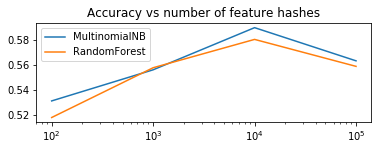

In [34]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_xscale('log')
ax.set_title("Accuracy vs number of feature hashes")
ax.plot(ns, accs, label='MultinomialNB')
ax.plot(ns, accs2, label='RandomForest')
ax.legend()

 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

Korzystając ze zbyt niskiej ilości haszowanych cech możemy stracić nawet ponad 10% (ponad 5 punktów procentowych) trafności (accuracy) modelu. Również używając zbyt dużej ilości hashowanych cech, przetestowane, dość proste modele tracą na trafności klasyfikacji. Wygląda na to, że dla danego zbioru i reprezentacji danych (oraz pewnie danej funkcji haszującej) istnieje pewne optimum liczby haszowanych cech względem trafności klasyfikacji.

Klasyfikatory działają dobrze pomimo konfliktów ze względu na:

1) możliwość nauczenia się łącznego/wspólnego wpływu danych słów kolidujących (argument ten nie działa dla problemu OOV)

2) wnioskowania z pozostałych (szczególnie nie kolidujących pozycji)

3) czasem również - stosowania opcji alternate_sign, która powoduje, że błędy wynikające z kolizji się wzajemnie wykluczają zamiast gromadzić

Interpretacja takich skonfliktowanych cech może być podobna do argumentu nr 1 - taka cecha może modelować wspólny wpływ lub cechę zależną od kilku słów (i może to pomóc klasyfikatorowi o ile nie są to dokładnie przeciwstawne znaczenia - tzn. posiadają część wspólną jeśli chodzi o wnioskowanie na temat klasy z obecności takich słów).

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [152]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer

# get dict with index as words and values as clusters
d = pd.Series(brown_df.cluster.values,index=brown_df.word).to_dict()

# get lists (tweets) of lists of clusters (words)
Xc = [[d[word] for word in i.tokens if word in d] for i in training_set.tweets]

print("Unique clusters: " +str(len( set( [item for sublist in Xc for item in sublist]) ) ))

Xc_train, Xc_test, y_train, y_test = train_test_split(Xc, y, test_size=0.33, random_state=42)

cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)


Xc_train_vectorized = cv.fit_transform(Xc_train)
Xc_test_vectorized = cv.transform(Xc_test)

# checking OOV problem scale for train - test sets (previous print train+test vs only train)
print("Train unique clusters: " +str(Xc_train_vectorized.shape[1]))

clfC = MultinomialNB()
clfC2  = RandomForestClassifier(n_estimators=20, random_state=1)
clfC.fit(Xc_train_vectorized, y_train)
clfC2.fit(Xc_train_vectorized, y_train)
predC = clfC.predict(Xc_test_vectorized)
predC2 = clfC2.predict(Xc_test_vectorized)
accC = accuracy_score(y_test, predC)
accC2 = accuracy_score(y_test, predC2)

print("Accuracy, MultinomialNB: " +str(accC) +", RandomForest: " + str(accC2))

Unique clusters: 968
Train unique clusters: 966
Accuracy, MultinomialNB: 0.5943396226415094, RandomForest: 0.5682574916759157


- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

Wykorzystanie grup dało lepszy wynik od najlepszego wariantu haszowania cech dla klasyfikatora MultinomialNB, ale słabszy od najlepszego wariantu haszowania cech dla klasyfikatora RandomForest. Wygląda na to, że obie metody mają swoje zalety i żadna nie dominuje całkowicie drugiej.

Haszowanie cech;

zalety: 
- stała ilość cech - w przypadku pojawienia się nowych przykładów z nowymi słowami - doszkolenie klasyfikatora zamiast nauka od nowa
- możliwość nauczenia się reprezentacji łącznej kolidujących słów
- kontrolowana ilość cech

wady:
- utrata informacji / akumulowanie błędu w bardziej niefortunnych kolizjach (zależy od słów i problemu)
- reprezentacja słowa (hash) nie niesie ze sobą znaczenia samego w sobie

Wykorzystanie grup:

zalety:
- reprezentacja słowa (grupa) ma znaczenie (zależne od algorytmu grupującego)
- mała ilość, znaczących cech - lepsza generalizacja i oszczędność pamięci

wady:
- potencjalny brak grup (reprezentacji) dla nowych słów i konieczność przeszkolenia nie tylko klasyfikatora, ale wykonania algorytmu grupującego dla nowych przykładów z nowymi słowami